## Imports

In [1]:
import xarray as xr

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatter

In [3]:
# colorblind-friendly colormaps

!pip install cmcrameri

import cmcrameri.cm as cmc
import matplotlib.pyplot as plt
from cycler import cycler
    
#colorlist = ['c', 'm', 'y', 'k']
    
cmap = cmc.hawaiiS
    
custom_cycler = cycler(color=cmap.colors) #or simply color=colorlist

In [4]:
from typing import Union

## Open the data

In [5]:
# data in persistent bucket
target_url = 'gs://leap-persistent/tomnicholas/hero-calc/compute/llc4320/vort_strain_div_histogram_coarsen_nan_padding_3_hourly.zarr'

In [6]:
hist_ds = xr.open_dataset(target_url, engine="zarr", chunks={})

In [7]:
hist_ds['histogram_vort_strain_div'].isel(time=0).nbytes / 1e9

1.682792496

In [8]:
from xarray.indexes import PandasIndex

# have to add the index ourselves manually for some reason
hist_ds = hist_ds.set_xindex('region_num', PandasIndex)

## Correct PDF normalization

Division by 80 comes from 8 samples per day (3-hourly sampling of hourly data) over a 10-day period. 
This correction is currently required because I accidentally did `coarsen(time=8*10).sum(dim='time')` instead of `coarsen(time=8*10).mean(dim='time')` before saving to zarr.

In [9]:
hist_ds['histogram_vort_strain_div'] = hist_ds['histogram_vort_strain_div'] / 80

In [10]:
hist_ds

<xarray.Dataset>
Dimensions:                    (div_bin: 99, region: 438, time: 37,
                                vort_bin: 99, strain_bin: 49, vertices: 4)
Coordinates:
  * div_bin                    (div_bin) float64 -4.949 -4.848 ... 4.848 4.949
    face                       (region) int64 dask.array<chunksize=(13,), meta=np.ndarray>
    i_region_coarse            (region) int64 dask.array<chunksize=(438,), meta=np.ndarray>
    j_region_coarse            (region) int64 dask.array<chunksize=(438,), meta=np.ndarray>
  * region_num                 (region) int64 4 5 6 7 13 ... 791 792 793 798 799
  * strain_bin                 (strain_bin) float64 0.05102 0.1531 ... 4.949
  * time                       (time) datetime64[ns] 2011-09-17T22:30:00 ... ...
    vertices_latitude          (vertices, region) float32 dask.array<chunksize=(4, 438), meta=np.ndarray>
    vertices_longitude         (vertices, region) float32 dask.array<chunksize=(4, 438), meta=np.ndarray>
  * vort_bin                   (vort_bin) float64 -4.949 -4.848 ... 4.848 4.949
Dimensions without coordinates: region, vertices
Data variables:
    histogram_vort_strain_div  (time, region, vort_bin, strain_bin, div_bin) float64 dask.array<chunksize=(1, 1, 99, 49, 99), meta=np.ndarray>

## Choose region

In [11]:
region_name = "ACC"
region_slice = {'region_num': [289, 288, 297, 296]}

In [12]:
h = hist_ds['histogram_vort_strain_div'].sel(**region_slice).mean(dim='region')

In [13]:
h

<xarray.DataArray 'histogram_vort_strain_div' (time: 37, vort_bin: 99,
                                               strain_bin: 49, div_bin: 99)>
dask.array<mean_agg-aggregate, shape=(37, 99, 49, 99), dtype=float64, chunksize=(1, 99, 49, 99), chunktype=numpy.ndarray>
Coordinates:
  * div_bin     (div_bin) float64 -4.949 -4.848 -4.747 ... 4.747 4.848 4.949
  * strain_bin  (strain_bin) float64 0.05102 0.1531 0.2551 ... 4.745 4.847 4.949
  * time        (time) datetime64[ns] 2011-09-17T22:30:00 ... 2012-09-11T22:3...
  * vort_bin    (vort_bin) float64 -4.949 -4.848 -4.747 ... 4.747 4.848 4.949

## Instantaneous vort / strain / div fields

In [17]:
import xarray as xr

In [18]:
from xarray.core.indexes import PandasIndex

In [19]:
import dask

In [20]:
import numpy as np

In [21]:
import xgcm
from typing import Annotated

In [22]:
from xhistogram.xarray import histogram as xhist_histogram

In [23]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [24]:
def open_llc4320_velocity_data(chunks='auto', time_range=None):
    
    ds_SSU = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/ssu", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        inline_array=True,
        consolidated=True, 
    )
    
    ds_SSV = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/ssv", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        inline_array=True,
        consolidated=True, 
    )
    
    # Open grid data
    ds_grid = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/grid", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        inline_array=True,
        consolidated=True, 
    )
    
    coords_to_keep = ['XC', 'YC', 'dxC', 'dyC', 'dxG', 'dyG', 'rAz', 'rA', 'Depth']
    ds_grid = ds_grid.reset_coords()[coords_to_keep]
    
    ds = xr.merge([ds_SSU, ds_SSV, ds_grid])
    
    if time_range is not None:
        ds = ds.isel(time=time_range)
        
    ds = ds.chunk(chunks)
    
    return ds, ds_grid
    

In [25]:
ds, ds_grid = open_llc4320_velocity_data(chunks={})

In [26]:
ds

<xarray.Dataset>
Dimensions:  (time: 9030, face: 13, j: 4320, i_g: 4320, j_g: 4320, i: 4320)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
Data variables:
    U        (time, face, j, i_g) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    V        (time, face, j_g, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxC      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyC      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxG      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyG      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAz      (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rA       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...
    source:       MITgcm
    title:        netCDF wrapper of MITgcm MDS binary data

In [27]:
# first downsample to daily data
#ds = ds.isel(time=slice(None, None, 24)) 

In [28]:
# just a few faces and time slices for debugging
#ds = ds.isel(face=[0, 1], time=[0, 10])
#ds_grid = ds_grid.isel(face=[0, 1])

### Create xGCM grid

Only use a couple of faces and times to allow us to visualize task graph

In [29]:
#ds = ds.isel(face=slice(0,2), time=slice(0,2))
#ds_grid = ds_grid.isel(face=slice(0,2))

In [30]:
grid = xgcm.Grid(ds_grid, periodic=False)

### Define vort/strain/divergence calculation

In [31]:
def calc_f_coriolis(ds_grid):
    """Calculate the coriolis frequency for all latitudes"""
    
    lat = ds_grid['YC'].reset_coords(drop=True).rename('lat')
    
    rotation_rate = 7.2921e-5  # rad/s
    f_coriolis = (
        2 * rotation_rate * np.sin(lat*np.pi/180)
    ).rename('f_coriolis')
    
    return f_coriolis

We want to calculate the integral formula for [relative vorticity](https://mitgcm.readthedocs.io/en/latest/algorithm/algorithm.html?highlight=vorticity#relative-vorticity) in terms of circulation around a grid cell:

$$
  \zeta_3 = \frac{\Gamma}{A_\zeta} = \frac{1}{{\cal A}_\zeta} ( \delta_i \Delta y_c v - \delta_j \Delta x_c u )
$$

where $u$ and $v$ are horizontal and vertical components of surface velocity respectively.

In [32]:
@xgcm.as_grid_ufunc(
    boundary_width={"X": (1, 0), "Y": (1, 0)},
    boundary="fill",
    fill_value=np.nan,
    dask="parallelized",    
)
def vort(
    u:   Annotated[np.ndarray, "(Y:center,X:left)"],
    dxc: Annotated[np.ndarray, "(Y:center,X:left)"],
    v:   Annotated[np.ndarray, "(Y:left,X:center)"],
    dyc: Annotated[np.ndarray, "(Y:left,X:center)"],
    raz: Annotated[np.ndarray, "(Y:left,X:left)"],
) ->     Annotated[np.ndarray, "(Y:left,X:left)"]:
    """Dimensional vorticity"""
    
    u_trans = u * dxc
    v_trans = v * dyc
    v_diff_x = v_trans[..., 1:, 1:] - v_trans[..., 1:, :-1]
    u_diff_y = u_trans[..., 1:, 1:] - u_trans[..., :-1, 1:]
    return (v_diff_x - u_diff_y) / raz[..., 1:, 1:]

In [33]:
# with dask.config.set({'optimization.fuse.ave-width': 5, 'optimization.fuse.max-height': 20}):
#     graph = ζ.data.visualize(optimize_graph=True, color="order", cmap="autumn", node_attr={"penwidth": "4"})
    
# graph

In [34]:
# plot vorticity using hvplot
#ζ.isel(time=0).hvplot(x="i", y="j", rasterize=True,  width=500, height=400, cmap="RdBu_r")#, clim=(-5e-5, 5e-5))

We also want the **strain magnitude**, given by the vector magnitude of the two strain components, normal strain ($\sigma_n$) and shear strain ($\sigma_s$)

$$
\sigma = \sqrt{\sigma_n^2 + \sigma_s^2}
$$

where the components are given in terms of surface velocity components $u$ and $v$ as

$$
\sigma_n = \frac{\partial u}{\partial x} - \frac{\partial v}{\partial y}
$$
$$
\sigma_s = \frac{\partial v}{\partial x} + \frac{\partial u}{\partial y}
$$

In [35]:
@xgcm.as_grid_ufunc(
    boundary_width={"X": (1, 0), "Y": (1, 0)},
    boundary="fill",
    fill_value=np.nan,
    dask="parallelized",    
)
def strain(
    u:   Annotated[np.ndarray, "(Y:center,X:left)"],
    dxc: Annotated[np.ndarray, "(Y:center,X:left)"],
    v:   Annotated[np.ndarray, "(Y:left,X:center)"],
    dyc: Annotated[np.ndarray, "(Y:left,X:center)"],
) ->     Annotated[np.ndarray, "(Y:left,X:left)"]:
    u_diff_x = (u[..., 1:] - u[..., :-1]) / dxc[..., 1:]
    v_diff_x = (v[..., 1:] - v[..., :-1]) / dxc[..., 1:]
    u_diff_y = (u[..., 1:, :] - u[..., :-1, :]) / dyc[..., 1:, :]
    v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) / dyc[..., 1:, :]
    
    u_diff_x_trimmed = u_diff_x[..., 1:, :]
    v_diff_x_trimmed = v_diff_x[..., 1:, :]
    u_diff_y_trimmed = u_diff_y[..., 1:]
    v_diff_y_trimmed = v_diff_y[..., 1:]
    
    strain_normal = u_diff_x_trimmed - v_diff_y_trimmed
    strain_shear = v_diff_x_trimmed + u_diff_y_trimmed
    
    # TODO: interpolate the shear strain onto the positions of the normal strain
    # For now, we just pretend they are at the same grid point
    strain_mag = np.sqrt(strain_normal ** 2 +  strain_shear ** 2)
    
    return strain_mag

Finally we want **divergence**, defined as


$$
D = \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y}
$$

but [represented in MITgcm](https://mitgcm.readthedocs.io/en/latest/algorithm/algorithm.html?highlight=divergence#horizontal-divergence) as 

$$
D = \frac{1}{A_c h_c} \left( \delta_i \Delta y_g h_w u + \delta_j \Delta x_g h_s v\right)
$$

In [36]:
@xgcm.as_grid_ufunc(
    boundary_width={"X": (1, 0), "Y": (1, 0)},
    boundary="fill",
    fill_value=np.nan,
    dask="parallelized",
)
def divergence(
    u:   Annotated[np.ndarray, "(Y:center,X:left)"],
    dxg: Annotated[np.ndarray, "(Y:left,X:center)"],
    v:   Annotated[np.ndarray, "(Y:left,X:center)"],
    dyg: Annotated[np.ndarray, "(Y:center,X:left)"],
    ra:  Annotated[np.ndarray, "(Y:center,X:center)"],
) ->     Annotated[np.ndarray, "(Y:center,X:center)"]:
    
    u_diff_x = (u[..., 1:] - u[..., :-1]) * dxg[..., 1:]
    v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) * dyg[..., 1:, :]
    
    u_diff_x_trimmed = u_diff_x[..., 1:, :]
    v_diff_y_trimmed = v_diff_y[..., 1:]
    
    divergence = (u_diff_x_trimmed + v_diff_y_trimmed) / ra[..., 1:, 1:]
    
    return divergence

In [37]:
def calc_vort_strain_div(ds, grid):
    """Calculate normalised vorticity, strain and divergence from U and V."""
    
    # vorticity
    ζ = vort(grid, ds.U, ds.dxC, ds.V, ds.dyC, ds.rAz, axis= 5 * [("Y", "X")])
    ζ = ζ.assign_coords({"time": ds.time.values})  # TODO won't need this line once xgcm #575 is fixed
    ζ = ζ.rename({"i_g": "i", "j_g": "j"})  # pretend it's now on cell centers to match other fields
    
    # strain
    σ = strain(grid, ds.U, ds.dxC, ds.V, ds.dyC, axis=4 * [("Y", "X")])
    σ = σ.assign_coords({"time": ds.time.values})
    σ = σ.rename({"i_g": "i", "j_g": "j"})
    
    # divergence
    D = divergence(grid, ds.U, ds.dxG, ds.V, ds.dyG, ds.rA, axis= 5 * [("Y", "X")])# / abs(f_coriolis)
    D = D.assign_coords({"time": ds.time.values})
    D = D.rename("div")
    
    # Normalise
    # TODO: Would be neater to normalise inside grid ufunc but then we would also pad f unneccessarily     
    f_coriolis = calc_f_coriolis(ds_grid)
    ζ = ζ / f_coriolis
    σ = σ / abs(f_coriolis)
    D = D / abs(f_coriolis)
    
    # merge everything
    results = xr.merge(
        [
            ζ.rename("vort"),
            σ.rename("strain"),
            D.rename("div"),
            f_coriolis,
            ds_grid[['XC', 'YC', 'rA', 'Depth']]
        ]
    ).set_coords(['XC', 'YC', 'rA', 'Depth'])
    
    return results

In [38]:
results = calc_vort_strain_div(ds, grid)

In [39]:
results

<xarray.Dataset>
Dimensions:     (face: 13, i: 4320, j: 4320, time: 9030)
Coordinates:
  * face        (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i           (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j           (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time        (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
    XC          (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC          (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rA          (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
Data variables:
    vort        (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    strain      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    div         (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    f_coriolis  (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>

### Coarsen fields into regions of interest

In [40]:
def split_into_regions(results):#, vertices_longitude, vertices_latitude):
    
    regions = results.coarsen(
        i=540,
        j=540,
    ).construct(
        i=("i_region_coarse", "i_region"),
        j=("j_region_coarse", "j_region"),
    ).stack(region=['face', 'i_region_coarse', 'j_region_coarse'])
    
    #regions = regions.assign_coords(vertices_longitude=vertices_longitude, vertices_latitude=vertices_latitude)
    
    # keep a unique number for each region, and give it an index
    regions = regions.assign_coords(region_num=('region', np.arange(len(regions.region))))
    #regions = regions.set_xindex('region_num', PandasIndex)
    
    return regions

In [41]:
regions = split_into_regions(results)

In [42]:
regions

<xarray.Dataset>
Dimensions:          (i_region: 540, region: 832, j_region: 540, time: 9030)
Coordinates:
    i                (i_region, region) int64 0 0 0 0 0 ... 4319 4319 4319 4319
    j                (j_region, region) int64 0 540 1080 1620 ... 3239 3779 4319
  * time             (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
    XC               (j_region, i_region, region) float32 dask.array<chunksize=(540, 540, 64), meta=np.ndarray>
    YC               (j_region, i_region, region) float32 dask.array<chunksize=(540, 540, 64), meta=np.ndarray>
    rA               (j_region, i_region, region) float32 dask.array<chunksize=(540, 540, 64), meta=np.ndarray>
    Depth            (j_region, i_region, region) float32 dask.array<chunksize=(540, 540, 64), meta=np.ndarray>
  * region           (region) object MultiIndex
  * face             (region) int64 0 0 0 0 0 0 0 0 ... 12 12 12 12 12 12 12 12
  * i_region_coarse  (region) int64 0 0 0 0 0 0 0 0 1 1 ... 6 6 7 7 7 7 7 7 7 7
  * j_region_coarse  (region) int64 0 1 2 3 4 5 6 7 0 1 ... 6 7 0 1 2 3 4 5 6 7
    region_num       (region) int64 0 1 2 3 4 5 6 ... 826 827 828 829 830 831
Dimensions without coordinates: i_region, j_region
Data variables:
    vort             (time, j_region, i_region, region) float32 dask.array<chunksize=(1, 540, 540, 64), meta=np.ndarray>
    strain           (time, j_region, i_region, region) float32 dask.array<chunksize=(1, 540, 540, 64), meta=np.ndarray>
    div              (time, j_region, i_region, region) float32 dask.array<chunksize=(1, 540, 540, 64), meta=np.ndarray>
    f_coriolis       (j_region, i_region, region) float32 dask.array<chunksize=(540, 540, 64), meta=np.ndarray>

In [43]:
regions = regions.set_xindex('region_num', PandasIndex)

In [44]:
local_fields = regions.sel(**region_slice)
local_fields

<xarray.Dataset>
Dimensions:          (i_region: 540, region: 4, j_region: 540, time: 9030)
Coordinates:
    i                (i_region, region) int64 2160 2160 2700 ... 2699 3239 3239
    j                (j_region, region) int64 540 0 540 0 ... 1079 539 1079 539
  * time             (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
    XC               (j_region, i_region, region) float32 dask.array<chunksize=(540, 540, 4), meta=np.ndarray>
    YC               (j_region, i_region, region) float32 dask.array<chunksize=(540, 540, 4), meta=np.ndarray>
    rA               (j_region, i_region, region) float32 dask.array<chunksize=(540, 540, 4), meta=np.ndarray>
    Depth            (j_region, i_region, region) float32 dask.array<chunksize=(540, 540, 4), meta=np.ndarray>
  * region           (region) object MultiIndex
  * face             (region) int64 4 4 4 4
  * i_region_coarse  (region) int64 4 4 5 5
  * j_region_coarse  (region) int64 1 0 1 0
  * region_num       (region) int64 289 288 297 296
Dimensions without coordinates: i_region, j_region
Data variables:
    vort             (time, j_region, i_region, region) float32 dask.array<chunksize=(1, 540, 540, 4), meta=np.ndarray>
    strain           (time, j_region, i_region, region) float32 dask.array<chunksize=(1, 540, 540, 4), meta=np.ndarray>
    div              (time, j_region, i_region, region) float32 dask.array<chunksize=(1, 540, 540, 4), meta=np.ndarray>
    f_coriolis       (j_region, i_region, region) float32 dask.array<chunksize=(540, 540, 4), meta=np.ndarray>

(Just choose part of this whole region to make plotting a snapshot consistent)

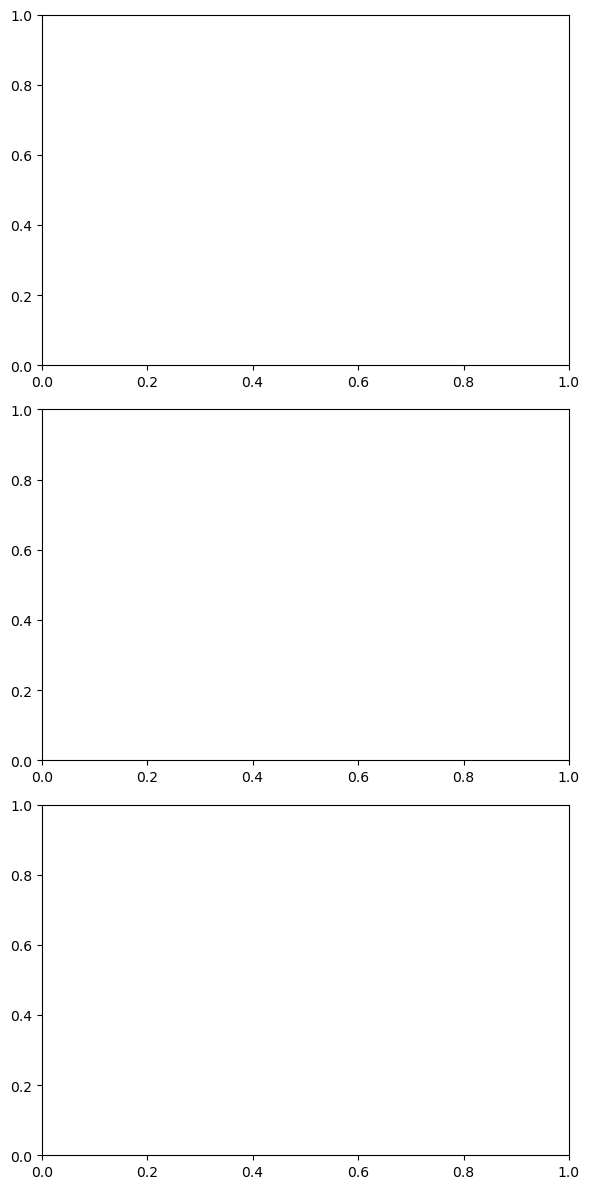

In [45]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 12), tight_layout=True)

In [46]:
#fig = plt.figure()
local_fields['vort'].isel(time=-1, region=0).plot(robust=True, rasterized=True, ax=ax1)
#pdf.savefig(fig)

In [47]:
#fig = plt.figure()
local_fields['strain'].isel(time=-1, region=0).plot(robust=True, rasterized=True, ax=ax2)
#pdf.savefig(fig)

/tmp/ipykernel_1041/1325305515.py:13: RuntimeWarning: invalid value encountered in divide
  u_diff_x = (u[..., 1:] - u[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_1041/1325305515.py:14: RuntimeWarning: invalid value encountered in divide
  v_diff_x = (v[..., 1:] - v[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_1041/1325305515.py:15: RuntimeWarning: invalid value encountered in divide
  u_diff_y = (u[..., 1:, :] - u[..., :-1, :]) / dyc[..., 1:, :]
/tmp/ipykernel_1041/1325305515.py:16: RuntimeWarning: invalid value encountered in divide
  v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) / dyc[..., 1:, :]


In [48]:
#fig = plt.figure()
local_fields['div'].isel(time=-1, region=0).plot(robust=True, rasterized=True, ax=ax3)
#pdf.savefig(fig)

In [49]:
ax1.set_title("")
ax2.set_title("")
ax3.set_title("")

Text(0.5, 1.0, '')

In [50]:
ax1.set_aspect(1, adjustable='box')
ax2.set_aspect(1, adjustable='box')
ax3.set_aspect(1, adjustable='box')

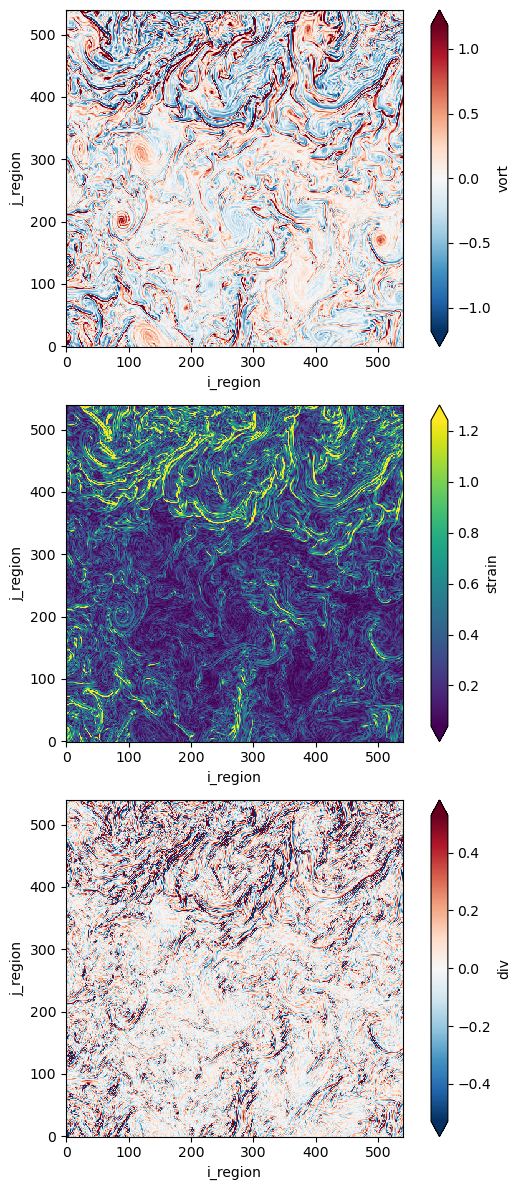

In [51]:
fig

# Histograms

Needed to integrate out various bin dimensions whilst preserving total integrated probability

In [52]:
def marginalize(
    pdf: xr.DataArray,
    dim: str | list = None,
    bin_widths: dict[str, Union[float, np.array, xr.DataArray]] = None,
) -> xr.DataArray:
    """
    Find the marginal probability distribution from the joint pdf.
    
    Integrates out one or more dimensions of the PDF to remove dependence on that quantity,
    whilst still preserving the total integrated probability.
    """
        
    if isinstance(dim, str):
        dim = [dim]
 
    all_bin_dims = ['vort_bin', 'strain_bin', 'div_bin']
   
    if dim is None:
        dim = all_bin_dims
    #if any(d not in all_bin_dims for d in dims):
    #    raise ValueError("Can't take marginal PDF over a dimension which is not a variable of the original PDF")

    if bin_widths is None:
        # Use defaults from vort/strain/div JPDF
        bin_widths = {
            'vort_bin': pdf['vort_bin'].diff('vort_bin')[0],
            'strain_bin': pdf['strain_bin'].diff('strain_bin')[0],
            'div_bin': pdf['div_bin'].diff('div_bin')[0],
        }
    
    marginal_pdf = pdf
    for bin_dim in dim:
        # TODO these would be slightly more accurate if we used xarray's integrate function
        marginal_pdf = marginal_pdf.sum(dim=bin_dim) * bin_widths[bin_dim]
        
    return marginal_pdf


def expectation(pdf: xr.DataArray, x: xr.DataArray, dim: str | list = None, bin_widths=None) -> xr.DataArray:
    """
    Take the expectation value of x over the given Probability Density Function.
    """
    
    return marginalize(pdf * x, dim=dim, bin_widths=bin_widths)

In [53]:
@xr.register_dataarray_accessor("pdf")
class DataArrayPDFAccessor:
    def __init__(self, da: xr.DataArray):
        self._da = da
        
    def marginalize(self, dim: str | list = None, bin_widths=None) -> xr.DataArray:
        return marginalize(self._da, dim, bin_widths)
    
    def expectation(self, x, dim: str | list = None, bin_widths=None) -> xr.DataArray:
        return expectation(self._da, x, dim, bin_widths)

In [54]:
h.pdf.marginalize(dim='div_bin')

<xarray.DataArray (time: 37, vort_bin: 99, strain_bin: 49)>
dask.array<mul, shape=(37, 99, 49), dtype=float64, chunksize=(1, 99, 49), chunktype=numpy.ndarray>
Coordinates:
  * strain_bin  (strain_bin) float64 0.05102 0.1531 0.2551 ... 4.745 4.847 4.949
  * time        (time) datetime64[ns] 2011-09-17T22:30:00 ... 2012-09-11T22:3...
  * vort_bin    (vort_bin) float64 -4.949 -4.848 -4.747 ... 4.747 4.848 4.949
    div_bin     float64 -4.848

In [55]:
def remove_bins_suffix(da: xr.DataArray) -> xr.DataArray:
    """Removes the suffix '_bins' from the name of the dataarray if present."""
    if da.name is not None and da.name.endswith("_bin"):
        return da.rename(da.name.removesuffix('_bin'))
    else:
        return da

    
def mean(pdf: xr.DataArray, x: xr.DataArray, dim: str | list = None, bin_widths=None) -> xr.DataArray:
    mu = expectation(pdf, x, dim, bin_widths)
    return remove_bins_suffix(mu)


def variance(pdf: xr.DataArray, x: xr.DataArray, dim: str | list = None, bin_widths=None) -> xr.DataArray:
    mu = mean(pdf, x, dim, bin_widths)
    var = expectation(pdf, (x - mu) ** 2, dim, bin_widths)
    return remove_bins_suffix(var)


def standard_deviation(pdf: xr.DataArray, x: xr.DataArray, dim: str | list = None, bin_widths=None) -> xr.DataArray:
    return np.sqrt(variance(pdf, x, dim, bin_widths))


def skewness(pdf: xr.DataArray, x: xr.DataArray, dim: str | list = None, bin_widths=None) -> xr.DataArray:
    mu = mean(pdf, x, dim, bin_widths)
    sigma = standard_deviation(pdf, x, dim, bin_widths)
    skew = expectation(pdf, (x - mu) ** 3, dim, bin_widths) / (sigma ** 3)
    return remove_bins_suffix(skew)


def kurtosis(pdf: xr.DataArray, x: xr.DataArray, dim: str | list = None, bin_widths=None) -> xr.DataArray:
    mu = mean(pdf, x, dim, bin_widths)
    sigma = standard_deviation(pdf, x, dim, bin_widths)
    kurt = expectation(pdf, (x - mu) ** 4, dim, bin_widths) / (sigma ** 4) - 3
    return remove_bins_suffix(kurt)

## Check PDF normalization

In [60]:
def integrated_probability(h_density):
    bin_volumes = h_density.coords['vort_bin'].diff('vort_bin')[0] * h_density.coords['strain_bin'].diff('strain_bin')[0] * h_density.coords['div_bin'].diff('div_bin')[0]
    
    integrated_probability = (h_density.fillna(0) * bin_volumes).sum(dim=['vort_bin', 'strain_bin', 'div_bin'])
    
    return integrated_probability

In [61]:
print(integrated_probability(h).max().values)
print(integrated_probability(h).min().values)

1.0021678235573002
1.001075292209672


In [58]:
print(expectation(h, 1.0).max().load())
print(expectation(h, 1.0).min().load())

<xarray.DataArray ()>
array(1.00216782)
Coordinates:
    vort_bin    float64 -4.848
    strain_bin  float64 0.1531
    div_bin     float64 -4.848
<xarray.DataArray ()>
array(1.00107529)
Coordinates:
    vort_bin    float64 -4.848
    strain_bin  float64 0.1531
    div_bin     float64 -4.848


Therefore the pdf integrates to almost 1.0 for each time and region.

## Check integrals

Taking the mean of the original data should give the same as the mean of the corresponding histogram

In [64]:
downsampled = local_fields.isel(time=slice(None, None, 3))

first_10_days = downsampled.isel(time=slice(0, 8*10))
first_10_days

<xarray.Dataset>
Dimensions:          (i_region: 540, region: 4, j_region: 540, time: 80)
Coordinates:
    i                (i_region, region) int64 2160 2160 2700 ... 2699 3239 3239
    j                (j_region, region) int64 540 0 540 0 ... 1079 539 1079 539
  * time             (time) datetime64[ns] 2011-09-13 ... 2011-09-22T21:00:00
    XC               (j_region, i_region, region) float32 dask.array<chunksize=(540, 540, 4), meta=np.ndarray>
    YC               (j_region, i_region, region) float32 dask.array<chunksize=(540, 540, 4), meta=np.ndarray>
    rA               (j_region, i_region, region) float32 dask.array<chunksize=(540, 540, 4), meta=np.ndarray>
    Depth            (j_region, i_region, region) float32 dask.array<chunksize=(540, 540, 4), meta=np.ndarray>
  * region           (region) object MultiIndex
  * face             (region) int64 4 4 4 4
  * i_region_coarse  (region) int64 4 4 5 5
  * j_region_coarse  (region) int64 1 0 1 0
  * region_num       (region) int64 289 288 297 296
Dimensions without coordinates: i_region, j_region
Data variables:
    vort             (time, j_region, i_region, region) float32 dask.array<chunksize=(1, 540, 540, 4), meta=np.ndarray>
    strain           (time, j_region, i_region, region) float32 dask.array<chunksize=(1, 540, 540, 4), meta=np.ndarray>
    div              (time, j_region, i_region, region) float32 dask.array<chunksize=(1, 540, 540, 4), meta=np.ndarray>
    f_coriolis       (j_region, i_region, region) float32 dask.array<chunksize=(540, 540, 4), meta=np.ndarray>

In [87]:
mean_vort_from_data = first_10_days['vort'].mean()
mean_vort_from_data.load()

<xarray.DataArray 'vort' ()>
array(0.00146506, dtype=float32)

In [88]:
mean_vort_from_hist = mean(h.isel(time=0), h['vort_bin'])
mean_vort_from_hist.load()

<xarray.DataArray ()>
array(0.0032109)
Coordinates:
    time        datetime64[ns] 2011-09-17T22:30:00
    vort_bin    float64 -4.848
    strain_bin  float64 0.1531
    div_bin     float64 -4.848

In [89]:
mean_strain_from_data = first_10_days['strain'].mean()
mean_strain_from_data.load()

/tmp/ipykernel_1041/1325305515.py:13: RuntimeWarning: invalid value encountered in divide
  u_diff_x = (u[..., 1:] - u[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_1041/1325305515.py:14: RuntimeWarning: invalid value encountered in divide
  v_diff_x = (v[..., 1:] - v[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_1041/1325305515.py:15: RuntimeWarning: invalid value encountered in divide
  u_diff_y = (u[..., 1:, :] - u[..., :-1, :]) / dyc[..., 1:, :]
/tmp/ipykernel_1041/1325305515.py:16: RuntimeWarning: invalid value encountered in divide
  v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) / dyc[..., 1:, :]


<xarray.DataArray 'strain' ()>
array(0.25241187, dtype=float32)

In [90]:
mean_strain_from_hist = mean(h.isel(time=0), h['strain_bin'])
mean_strain_from_hist.load()

<xarray.DataArray ()>
array(0.25568734)
Coordinates:
    time        datetime64[ns] 2011-09-17T22:30:00
    vort_bin    float64 -4.848
    strain_bin  float64 0.1531
    div_bin     float64 -4.848

In [91]:
mean_div_from_data = first_10_days['div'].mean()
mean_div_from_data.load()

<xarray.DataArray 'div' ()>
array(0.00052584, dtype=float32)

In [92]:
mean_div_from_hist = mean(h.isel(time=0), h['div_bin'])
mean_div_from_hist.load()

<xarray.DataArray ()>
array(0.00075863)
Coordinates:
    time        datetime64[ns] 2011-09-17T22:30:00
    vort_bin    float64 -4.848
    strain_bin  float64 0.1531
    div_bin     float64 -4.848